## 1- Importing libraries

In [6]:
%pip install FinanceDataReader

ERROR: Could not find a version that satisfies the requirement FinanceDataReader (from versions: none)
ERROR: No matching distribution found for FinanceDataReader
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import FinanceDataReader as fdr
import math
import warnings


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm

rcParams['figure.figsize'] = 13, 6 
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] =False
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'



ModuleNotFoundError: No module named 'FinanceDataReader'

## 2- Loading dataset

In [9]:
# Loading data with FinanceDataReader
df_wti = fdr.DataReader('CL=F', '2000')
df_brt = fdr.DataReader('BZ=F', '2000')
print(df_wti.shape)
print(df_brt.shape)
print(type(df_wti))
print(type(df_brt))

display(df_wti.tail())
display(df_brt.tail())


(6007, 6)
(4203, 6)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-01,83.139999,84.489998,82.599998,83.709999,83.709999,321059.0
2024-04-02,84.040001,85.500000,83.849998,85.150002,85.150002,344040.0
2024-04-03,85.459999,86.199997,84.849998,85.430000,85.430000,322549.0
2024-04-04,85.660004,87.220001,84.639999,86.589996,86.589996,359534.0
2024-04-05,86.860001,87.629997,86.320000,86.910004,86.910004,359534.0


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-01,86.930000,87.989998,86.400002,87.419998,87.419998,29598.0
2024-04-02,87.800003,89.279999,87.650002,88.919998,88.919998,40754.0
2024-04-03,89.209999,89.980003,88.680000,89.349998,89.349998,35138.0
2024-04-04,89.500000,91.300003,88.730003,90.650002,90.650002,38764.0
2024-04-05,91.010002,91.910004,90.570000,91.169998,91.169998,38764.0


In [11]:
# Extracting the 'Close' column
wti = df_wti['Close']
brt = df_brt['Close']

print(type(wti))
print(type(brt))
display(wti.tail())
display(brt.tail())

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


Date
2024-04-01    83.709999
2024-04-02    85.150002
2024-04-03    85.430000
2024-04-04    86.589996
2024-04-05    86.910004
Name: Close, dtype: float64

Date
2024-04-01    87.419998
2024-04-02    88.919998
2024-04-03    89.349998
2024-04-04    90.650002
2024-04-05    91.169998
Name: Close, dtype: float64

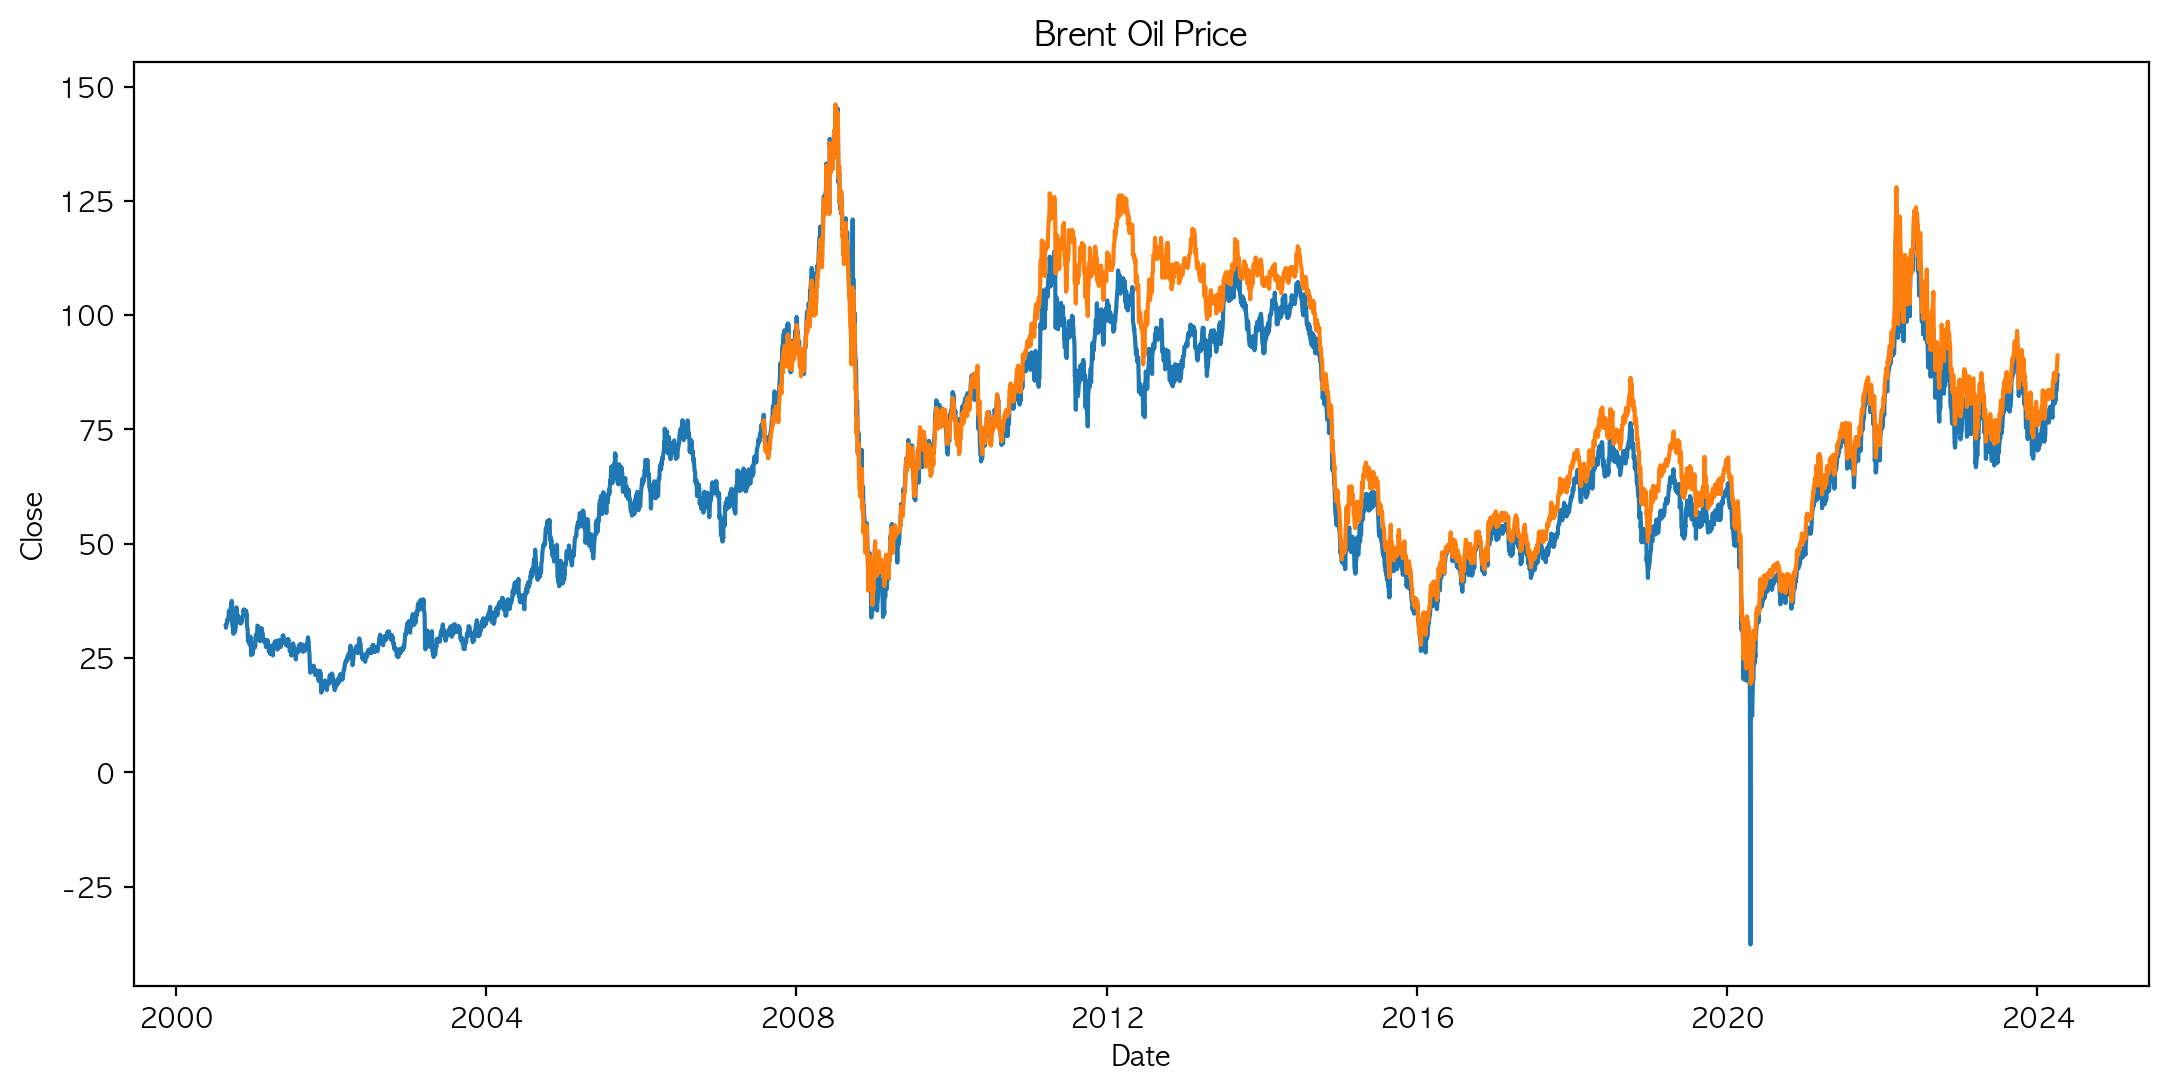

In [18]:
# Plotting the loaded dataset
sns.lineplot(data=wti)
plt.title('Crude Oil Price')
sns.lineplot(data=brt)
plt.title('Brent Oil Price')
plt.show()

## 3- Handling missing value

In [24]:
wti = wti.interpolate(method = 'time')
brt = brt.interpolate(method = 'time')

In [25]:
wti.isnull().sum()

0

In [26]:
brt.isnull().sum()

0

## 4- Log transformation

<Axes: xlabel='Date', ylabel='Close'>

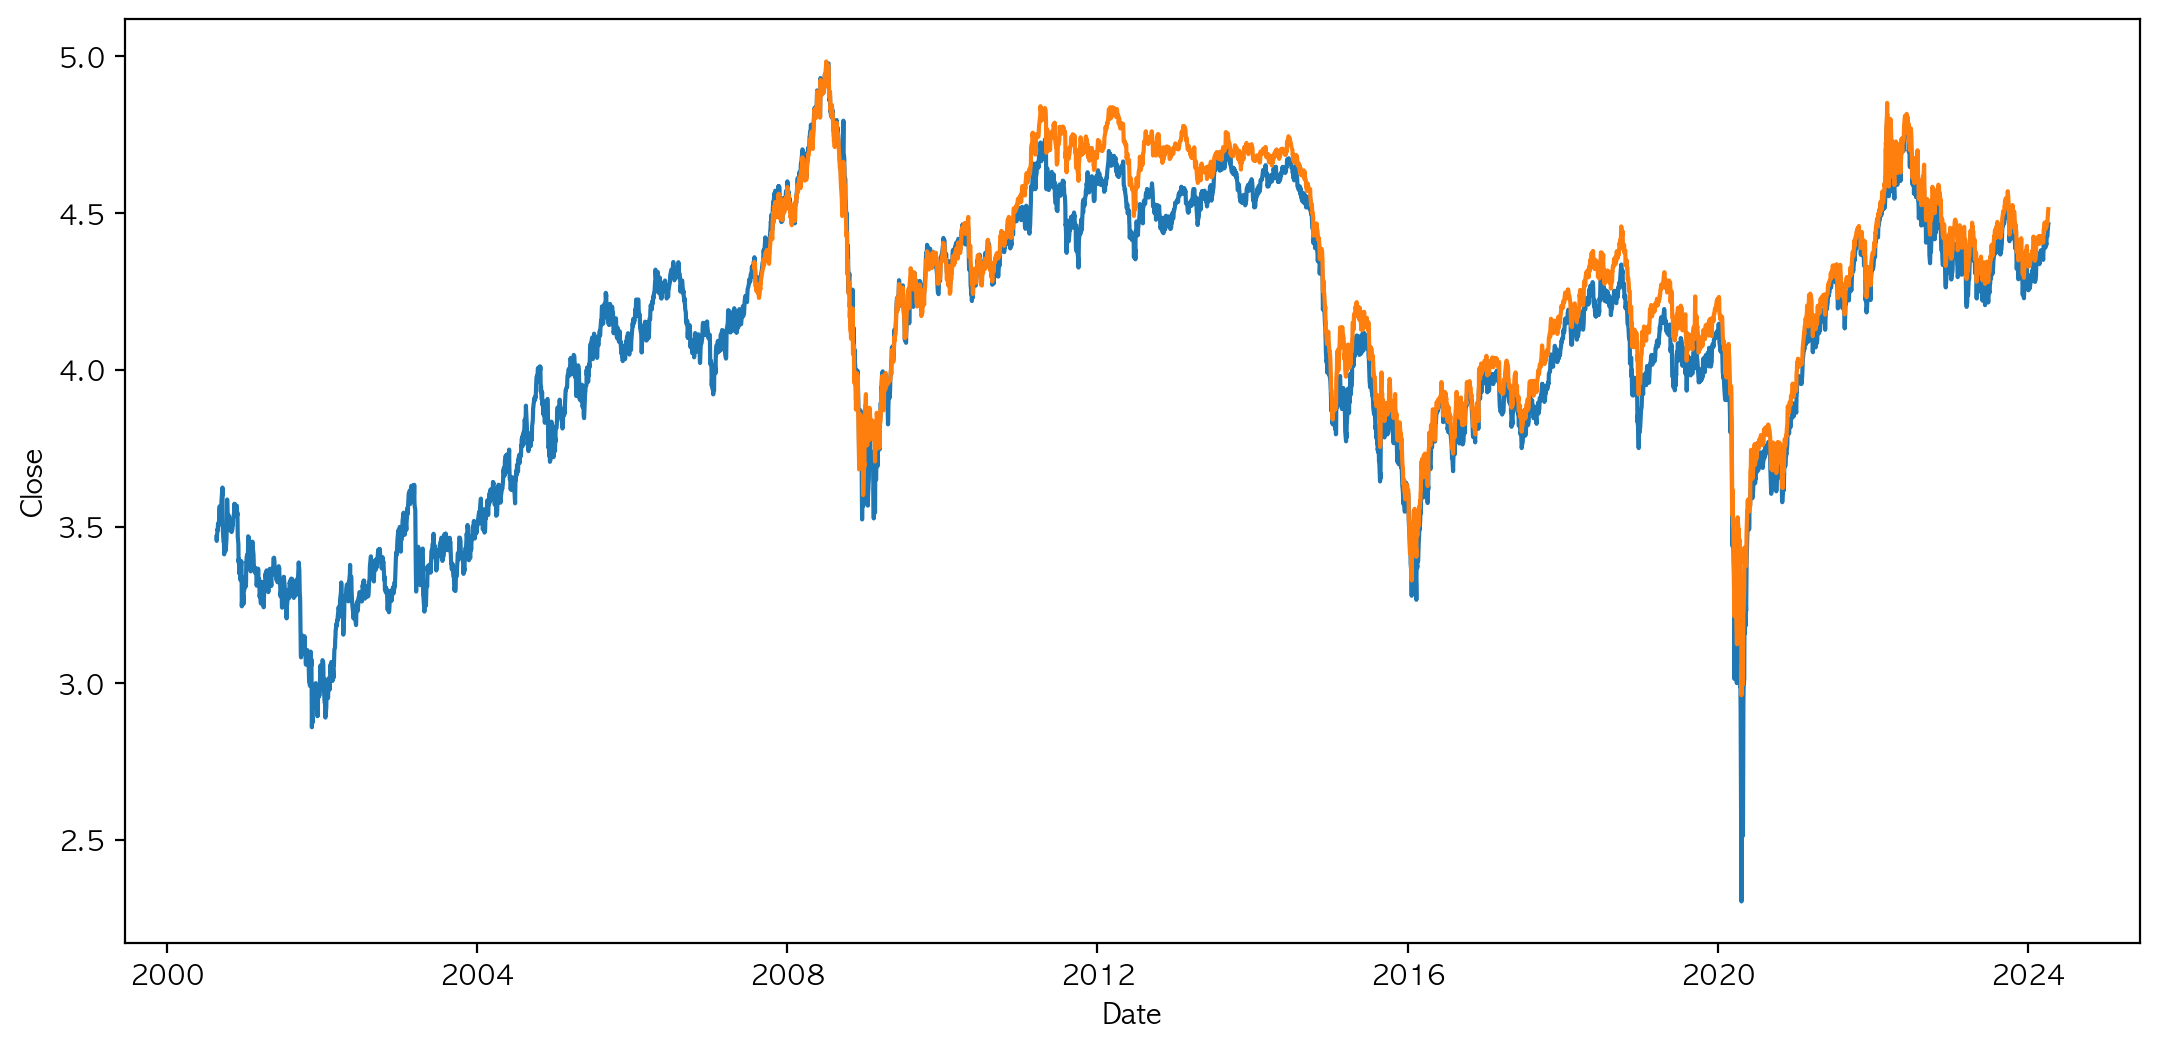

In [27]:
# Log transformation
wti_log = np.log(wti)
brt_log = np.log(brt)
sns.lineplot(data=wti_log)
sns.lineplot(data=brt_log)

## 5- Moving average

In [28]:
# Rolling mean and standard deviation
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html
def rolling_ts(timeseries, window):

    rollmean = timeseries.rolling(window = window).mean()  # moving average time series
    rollstd = timeseries.rolling(window = window).std()  # moving standard deviation time series

    plt.plot(timeseries, color = 'blue', label = 'Original')
    plt.plot(rollmean, color = 'red', label = 'Rolling Mean')
    plt.plot(rollstd, color = 'black', label = 'Rolling Std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.ylabel('Price')
    plt.xlabel('Date')
    plt.legend(loc = 'best')
    plt.grid(True)

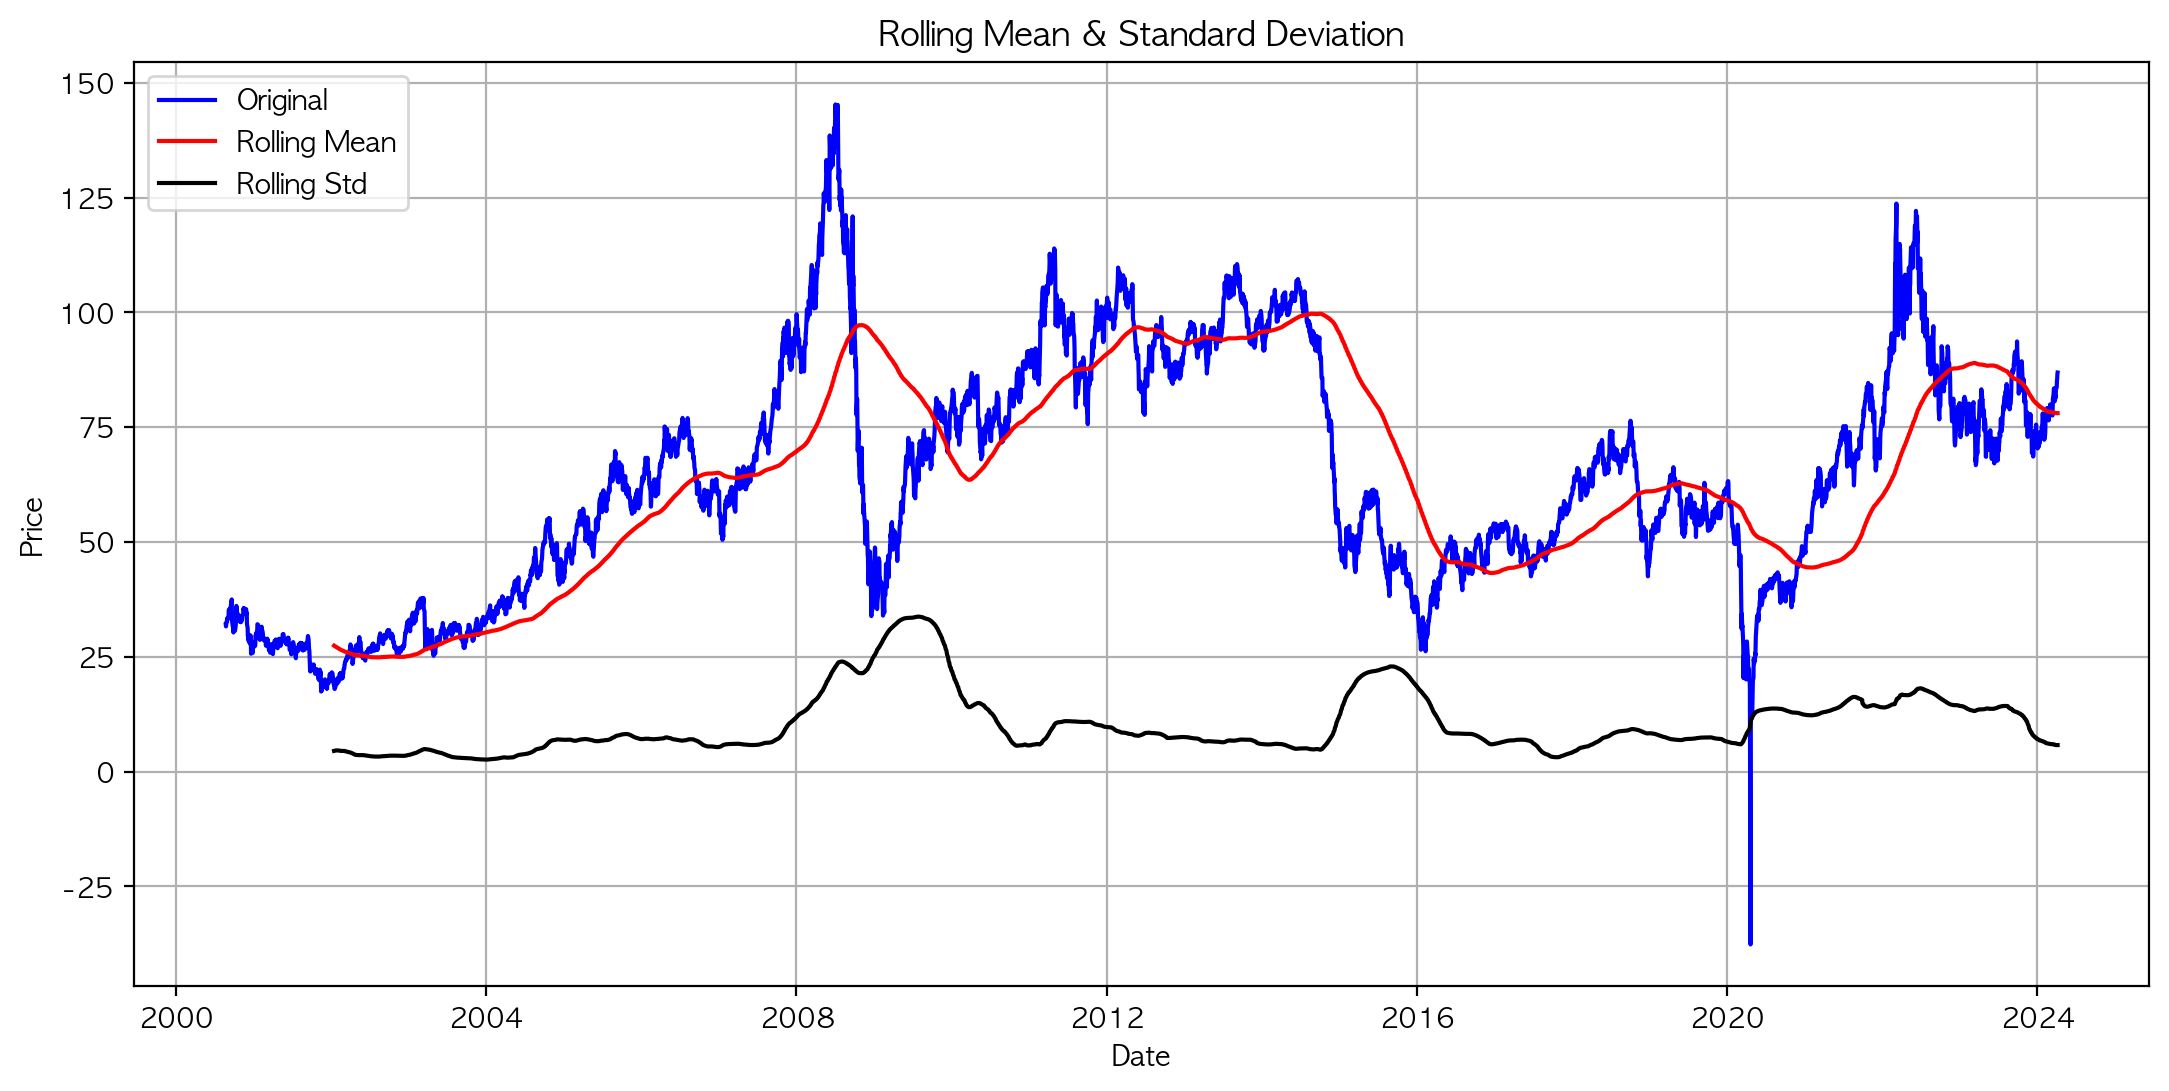

In [32]:
rolling_ts(wti, 365)

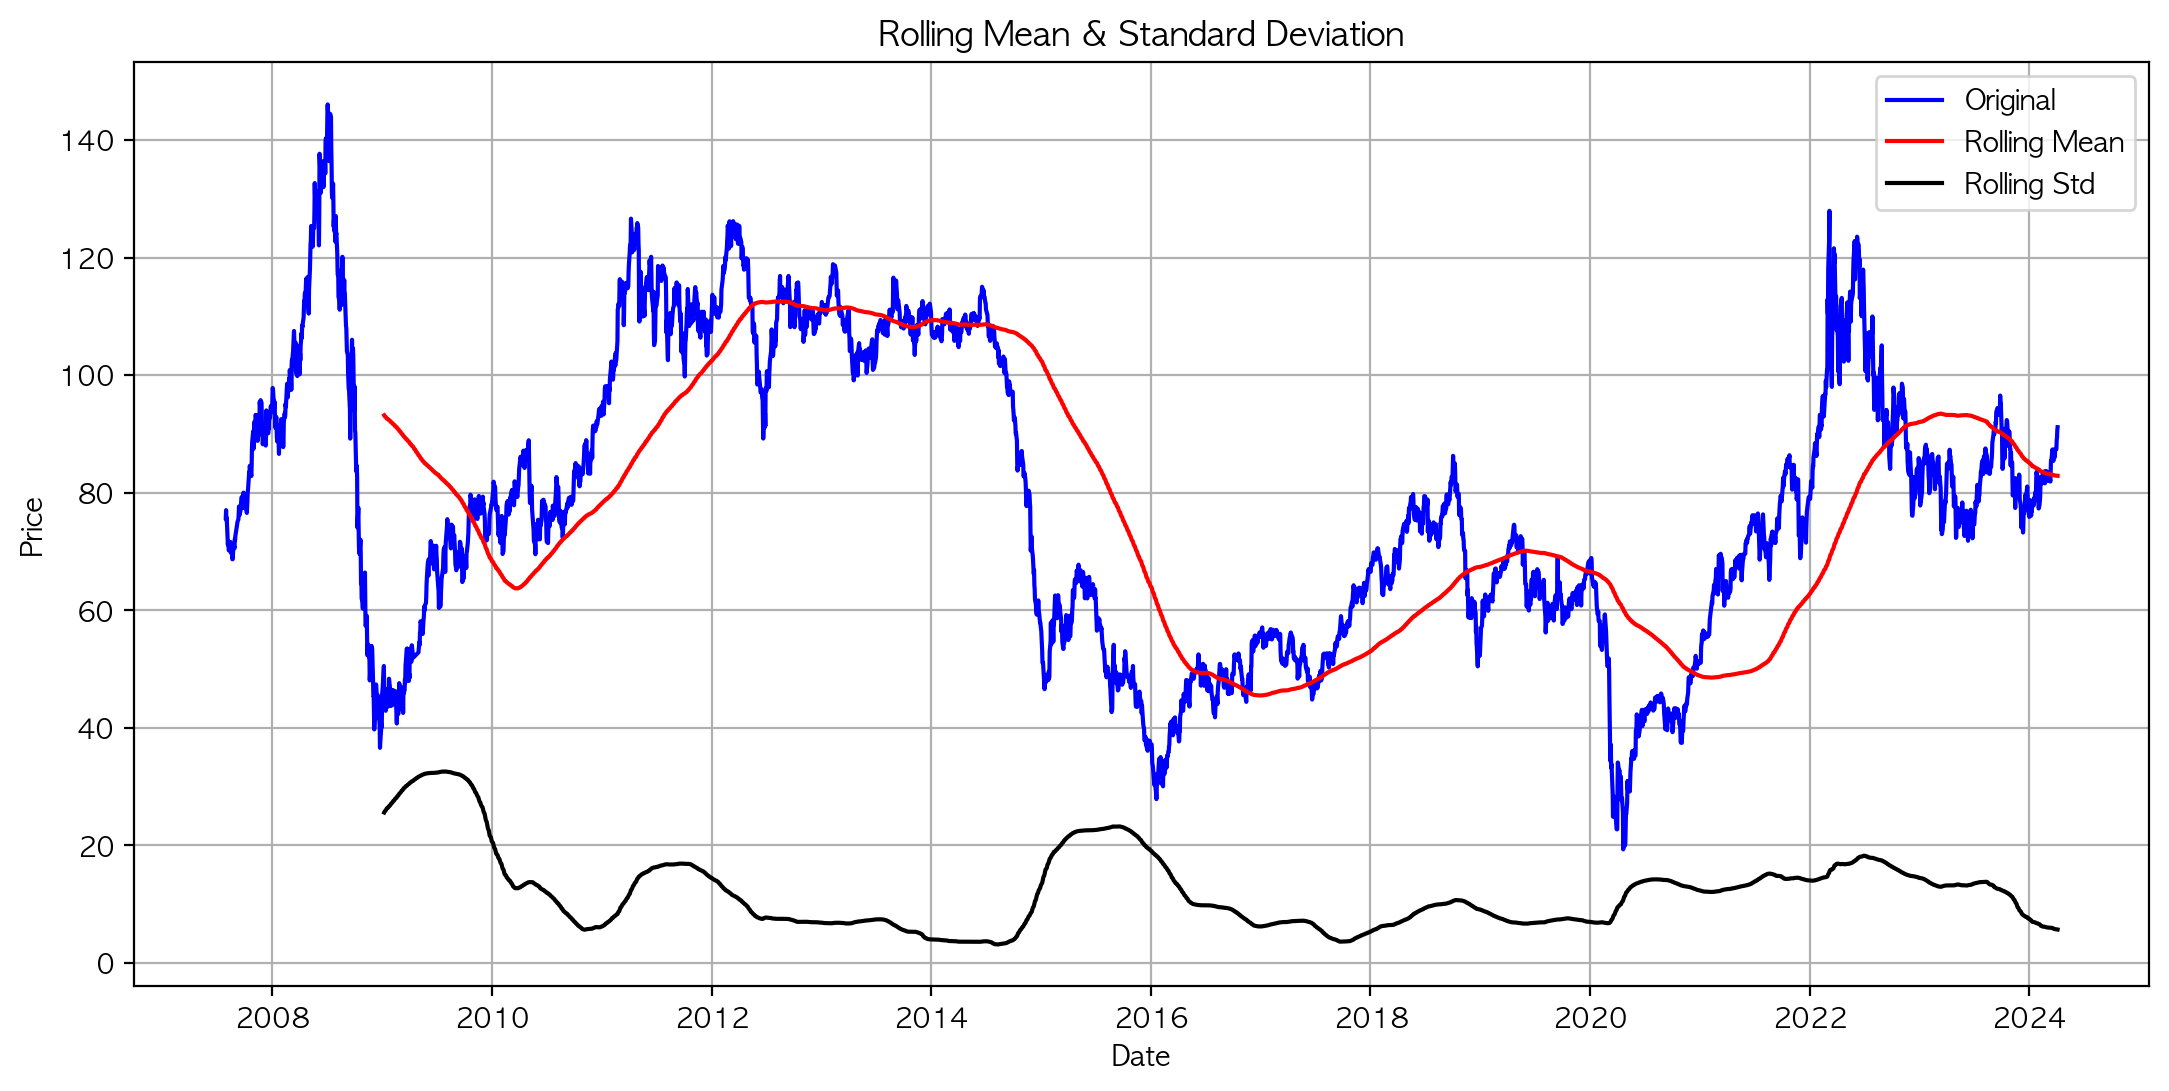

In [30]:
rolling_ts(brt, 365)

## 6- Time series decomposition

In [35]:
# Decomposition of time series
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
def decomposition_ts(timeseries, period, name):

    from statsmodels.tsa.seasonal import seasonal_decompose
    decomposition = seasonal_decompose(timeseries, model = 'additive', period = period)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(timeseries, label = 'Origianl', color = 'purple')
    plt.legend(loc = 'best')
    plt.grid(True)
    plt.title(f'Decomposition of Time Series : ({timeseries.name}) of ({name}) in period ({period})')

    plt.subplot(412)
    plt.plot(trend, label = 'Trend', color = 'blue')
    plt.legend(loc = 'best')
    plt.grid(True)

    plt.subplot(413)
    plt.plot(seasonal, label = 'Seasonality', color = 'green')
    plt.legend(loc = 'best')
    plt.grid(True)

    plt.subplot(414)
    plt.plot(residual, label = 'Residuals', color = 'orange')
    plt.legend(loc = 'best')
    plt.grid(True)
    
    plt.tight_layout()

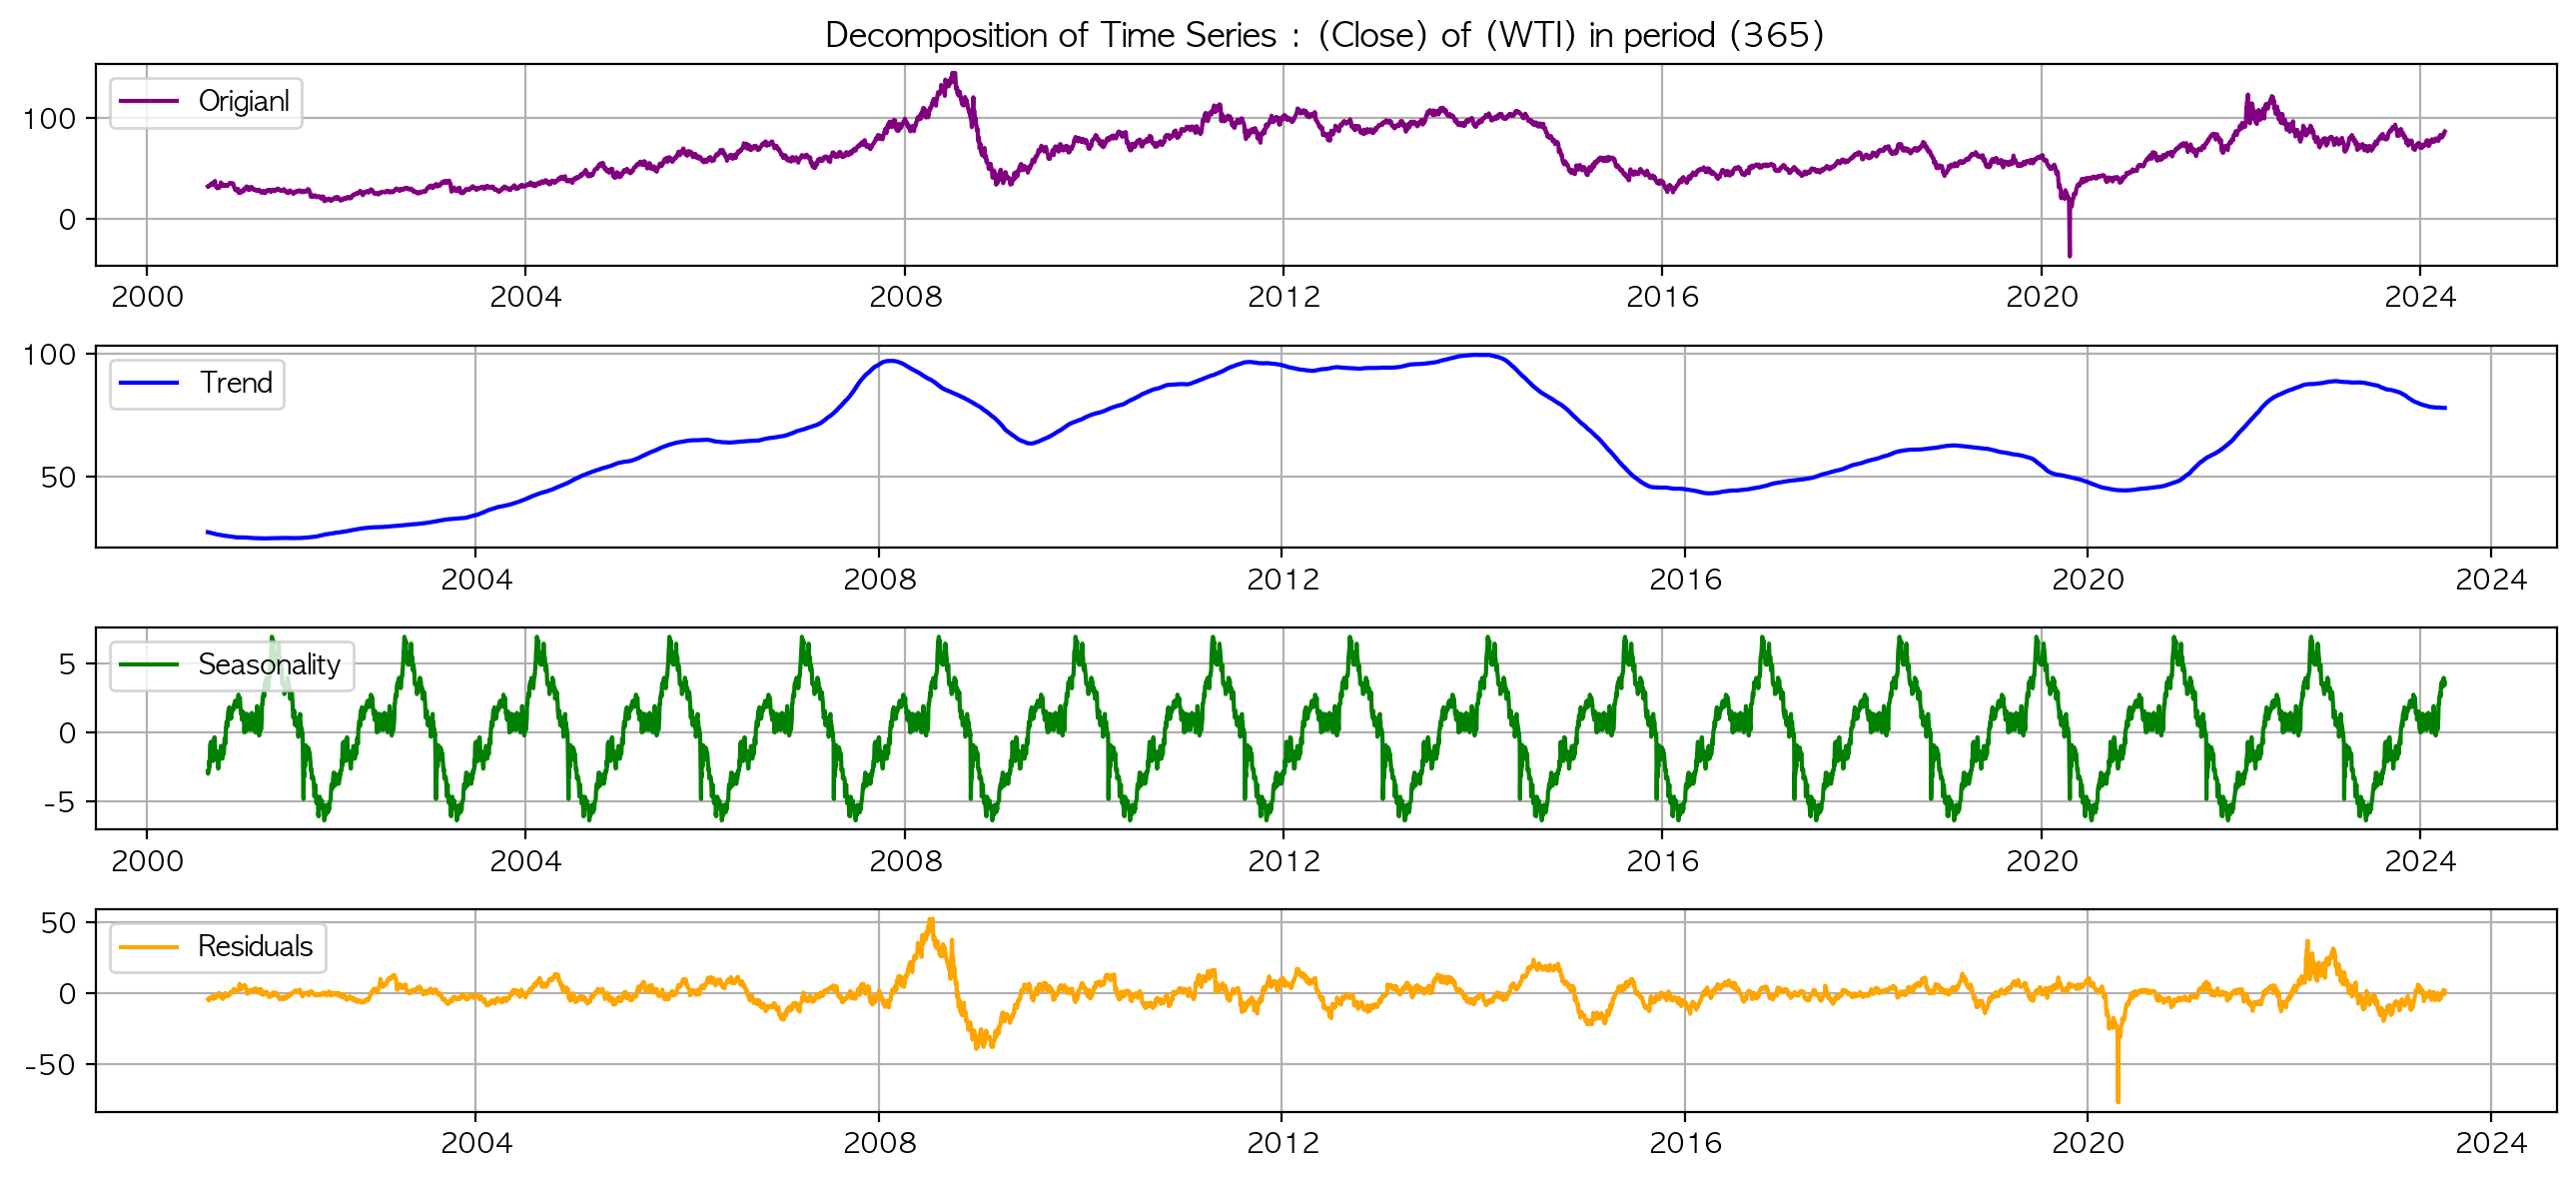

In [36]:
decomposition_ts(wti, 365, 'WTI')

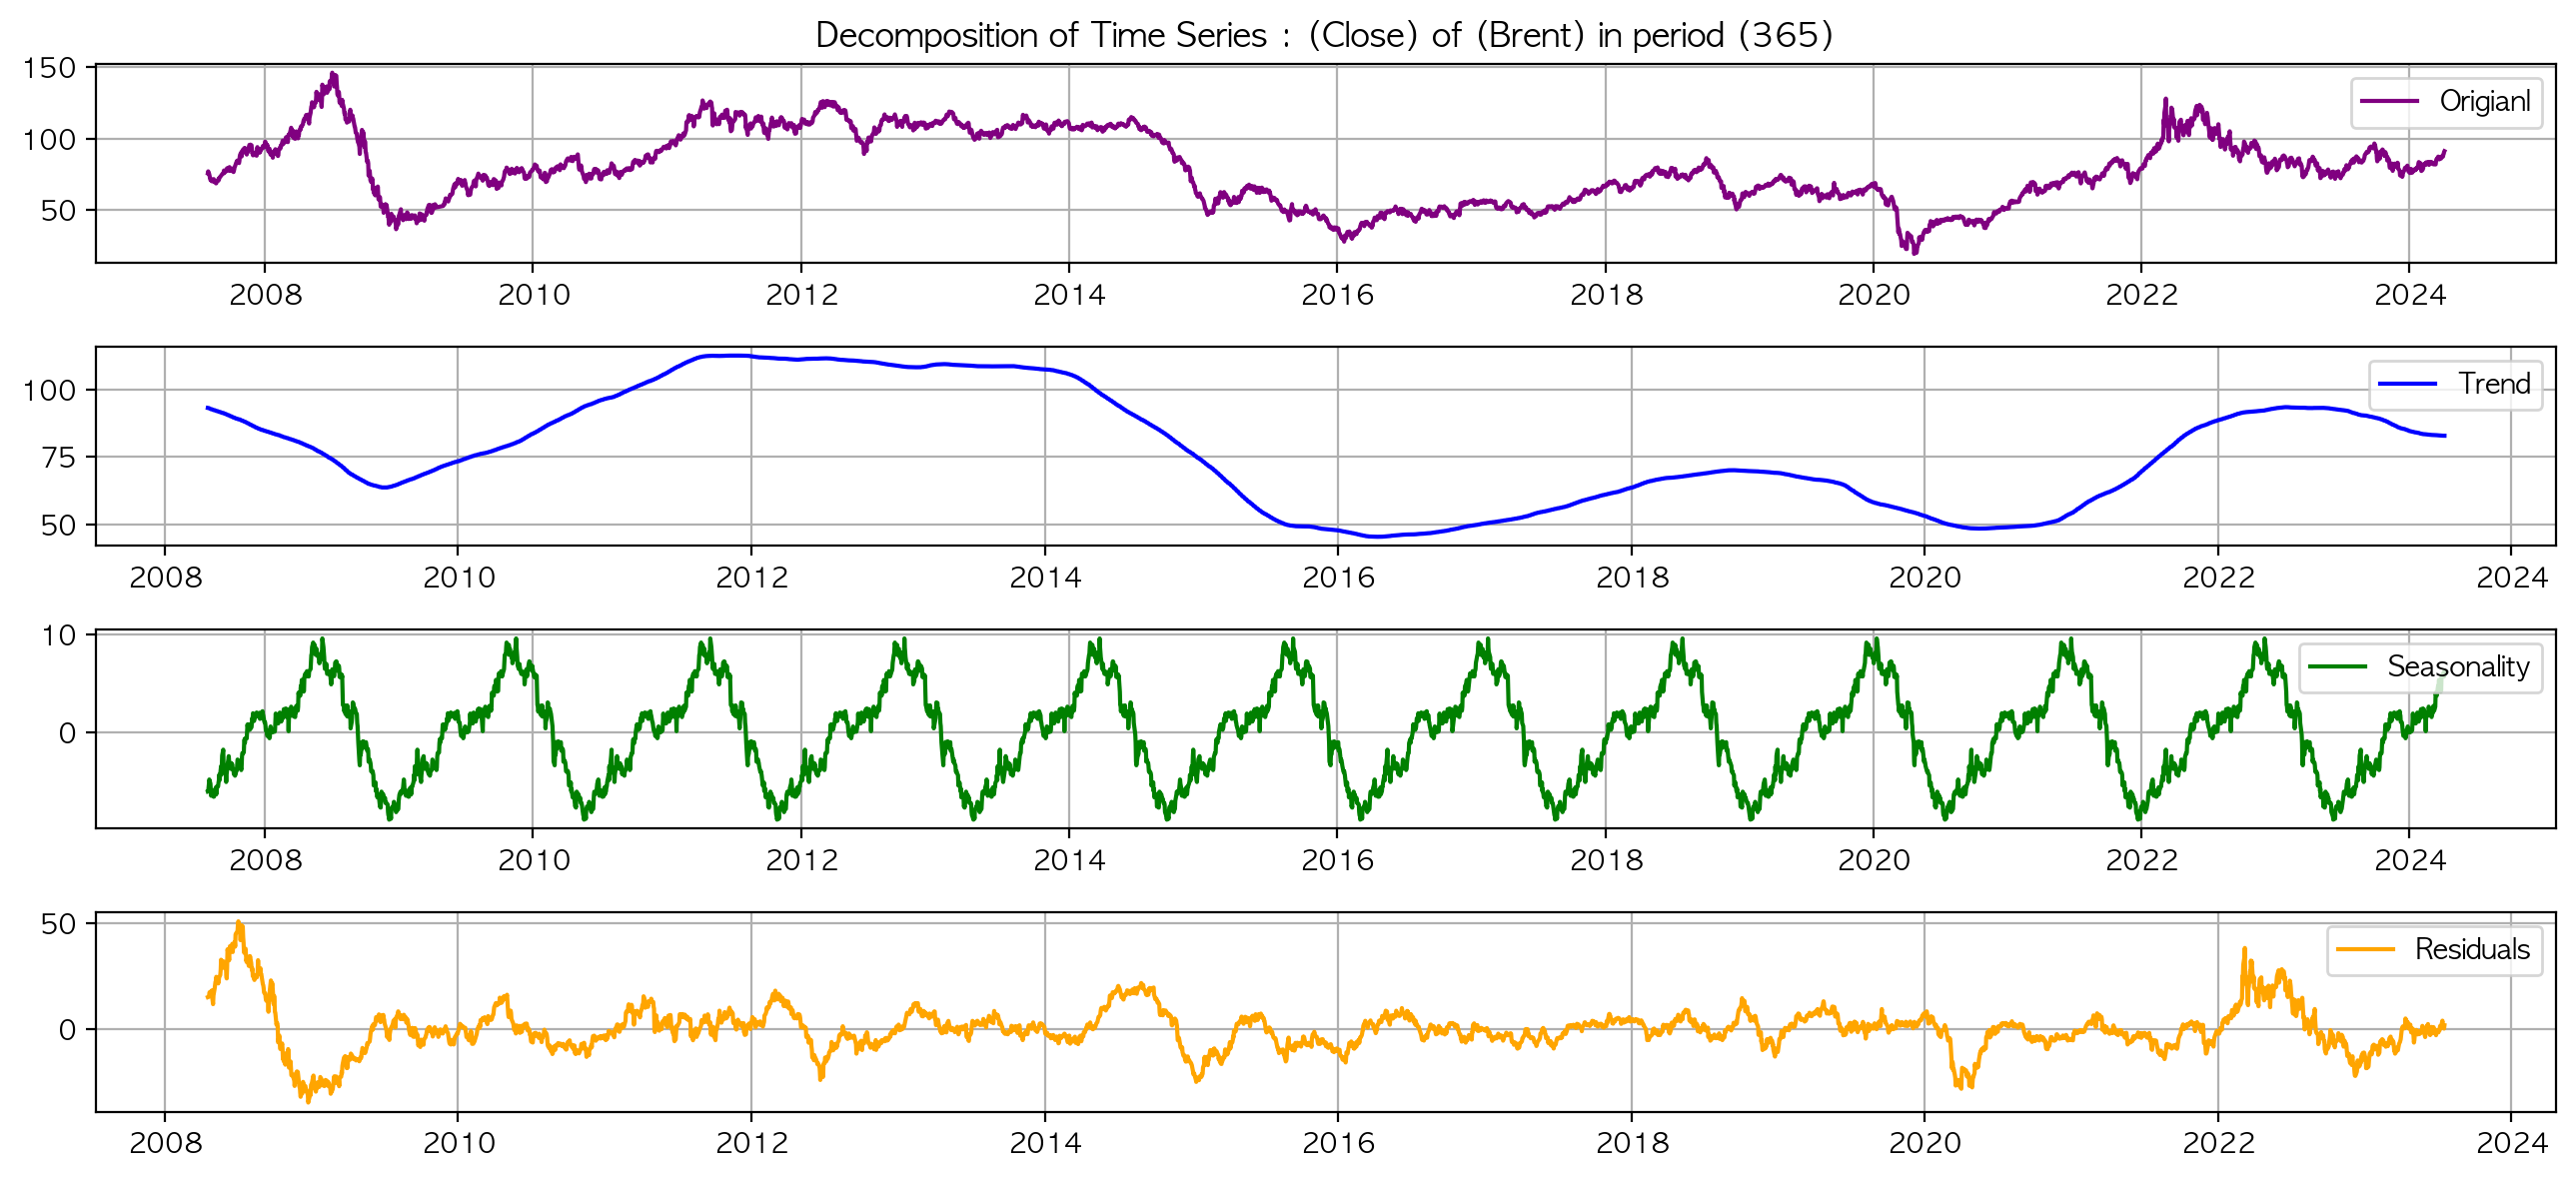

In [37]:
decomposition_ts(brt, 365, 'Brent')

## 7- ADF test

In [ ]:
# Augmented Dickey-Fuller Test
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
def adf_ts(timeseries):

    dftest = adfuller(timeseries, autolag='AIC')  
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# ChatGPT api

    # # OpenAI API Key
    # openai.api_key = os.getenv("OPENAI_API_KEY")

    # response = openai.Completion.create(
    #     model="gpt-3.5-turbo",
    #     prompt=str(dfoutput) + ' Feedback with simply meaning and conclusion in itemized list.',
    #     max_tokens=50,
    #     temperature=0.7
    # )

    # print(response.choices[0].text)

    from openai import OpenAI
    client = OpenAI()

    # Access the API key from environment variables
    openai.api_key = os.getenv("OPENAI_API_KEY")

    # Example: Creating a chat completion
    try:
        response = openai.Completion.create(
            model="text-davinci-003",  # Use an appropriate model
            prompt="This is a test. Provide feedback with simple meaning and conclusion in an itemized list.",
            max_tokens=50,
            temperature=0.7
        )
        print(response.choices[0].text)
    except Exception as e:
        print(f"An error occurred: {e}")